In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
df = pd.read_csv('./nlp_data/airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.tail()


,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(-20.0, 0, '1959-05'),
  Text(0.0, 0, '1949-01'),
  Text(20.0, 0, '1950-09'),
  Text(40.0, 0, '1952-05'),
  Text(60.0, 0, '1954-01'),
  Text(80.0, 0, '1955-09'),
  Text(100.0, 0, '1957-05'),
  Text(120.0, 0, '1959-01'),
  Text(140.0, 0, '1960-09'),
  Text(160.0, 0, '')])

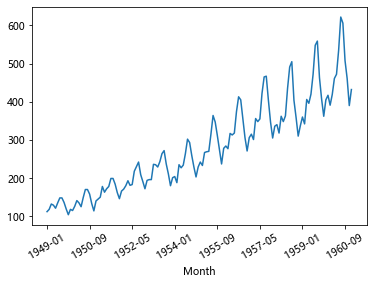

In [7]:
df2 = df.set_index("Month")
df2.plot(legend = None)
plt.xticks(rotation = 30)

In [9]:
len(df2)

144

In [10]:
from sklearn.preprocessing import MinMaxScaler
look_back = 1
def create_dataset(data1, look_back):
    x, y = [], []
    for i in range(len(data1) - look_back - 1):
        _x = data1[i:(i + look_back)]
        _y = data1[i + look_back]
        x.append(_x)
        y.append(_y)
        
    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

In [48]:
dataset = df2[['Passengers']].values.astype('float32')
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)
dataset.shape, trainY.shape


((144, 1), torch.Size([94, 1]))

In [49]:
dataset[-1]


array([0.6332046], dtype=float32)

In [50]:
trainX.shape, trainY.shape, testX.shape, testY.shape


(torch.Size([94, 1, 1]),
 torch.Size([94, 1]),
 torch.Size([46, 1, 1]),
 torch.Size([46, 1]))

In [51]:
torch.cat((trainX.squeeze(2), trainY), axis=1)


tensor([[0.0154, 0.0270],
        [0.0270, 0.0541],
        [0.0541, 0.0483],
        [0.0483, 0.0328],
        [0.0328, 0.0598],
        [0.0598, 0.0849],
        [0.0849, 0.0849],
        [0.0849, 0.0618],
        [0.0618, 0.0290],
        [0.0290, 0.0000],
        [0.0000, 0.0270],
        [0.0270, 0.0212],
        [0.0212, 0.0425],
        [0.0425, 0.0714],
        [0.0714, 0.0598],
        [0.0598, 0.0405],
        [0.0405, 0.0869],
        [0.0869, 0.1274],
        [0.1274, 0.1274],
        [0.1274, 0.1042],
        [0.1042, 0.0560],
        [0.0560, 0.0193],
        [0.0193, 0.0695],
        [0.0695, 0.0792],
        [0.0792, 0.0888],
        [0.0888, 0.1429],
        [0.1429, 0.1139],
        [0.1139, 0.1313],
        [0.1313, 0.1429],
        [0.1429, 0.1834],
        [0.1834, 0.1834],
        [0.1834, 0.1544],
        [0.1544, 0.1120],
        [0.1120, 0.0811],
        [0.0811, 0.1197],
        [0.1197, 0.1293],
        [0.1293, 0.1467],
        [0.1467, 0.1718],
        [0.1

In [52]:
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, hidden_size = 4, num_layers = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(1, self.hidden_size, num_layers = self.num_layers, batch_first = True)
        self.fc = nn.Linear(self.hidden_size, 1)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    def forward(self, x):
        
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))
        
        h_out = h_out[-1].view(-1, self.hidden_size)  
        return self.fc(h_out)
model = TimeSeriesModel(look_back, hidden_size=4, num_layers=1).to(device)


In [53]:
num_epochs = 2000
learning_rate = 0.01
def train(trainX, trainY):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(trainX)
        if epoch <= 0: print(outputs.shape)
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item():.5f}")
            
train(trainX, trainY)

torch.Size([94, 1])
Epoch: 0, loss: 0.13299
Epoch: 100, loss: 0.00949
Epoch: 200, loss: 0.00190
Epoch: 300, loss: 0.00190
Epoch: 400, loss: 0.00190
Epoch: 500, loss: 0.00190
Epoch: 600, loss: 0.00190
Epoch: 700, loss: 0.00190
Epoch: 800, loss: 0.00190
Epoch: 900, loss: 0.00190
Epoch: 1000, loss: 0.00190
Epoch: 1100, loss: 0.00190
Epoch: 1200, loss: 0.00190
Epoch: 1300, loss: 0.00190
Epoch: 1400, loss: 0.00190
Epoch: 1500, loss: 0.00190
Epoch: 1600, loss: 0.00190
Epoch: 1700, loss: 0.00190
Epoch: 1800, loss: 0.00190
Epoch: 1900, loss: 0.00190


In [54]:
model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()
trainPredict.shape

(94, 1)

In [55]:
trainY.shape, trainPredict.shape


(torch.Size([94, 1]), (94, 1))

In [56]:
from sklearn.metrics import mean_squared_error
import math

trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

(94, 1) (94, 1)


In [58]:
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

Train RMSE: 22.56
Test RMSE:  57.96


In [61]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+look_back, :] = trainPredict

In [62]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

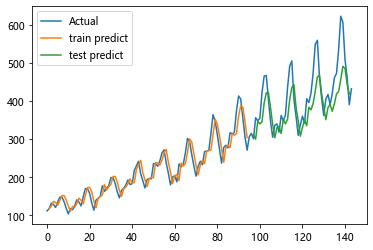

In [63]:
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()

In [64]:
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=1).to(device)
train(trainX, trainY)

torch.Size([92, 1])
Epoch: 0, loss: 0.06211
Epoch: 100, loss: 0.00322
Epoch: 200, loss: 0.00224
Epoch: 300, loss: 0.00178
Epoch: 400, loss: 0.00166
Epoch: 500, loss: 0.00160
Epoch: 600, loss: 0.00157
Epoch: 700, loss: 0.00155
Epoch: 800, loss: 0.00154
Epoch: 900, loss: 0.00153
Epoch: 1000, loss: 0.00152
Epoch: 1100, loss: 0.00151
Epoch: 1200, loss: 0.00151
Epoch: 1300, loss: 0.00150
Epoch: 1400, loss: 0.00150
Epoch: 1500, loss: 0.00149
Epoch: 1600, loss: 0.00149
Epoch: 1700, loss: 0.00149
Epoch: 1800, loss: 0.00148
Epoch: 1900, loss: 0.00148


In [65]:
from sklearn.metrics import mean_squared_error
import math 

model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(92, 1) (92, 1)
Train RMSE: 19.89
Test RMSE:  61.85


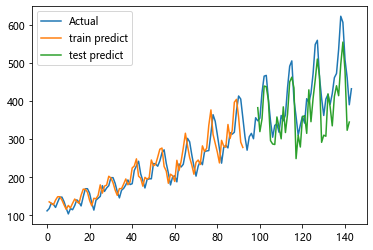

In [66]:
# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:trainPredict.shape[0]+1:, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()

### LSTM

In [67]:
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, hidden_size=4, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(1, self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        #print(x.shape)
        # rnn_out, h_out = self.rnn(x)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)        
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))
        #print(h_out.shape)
        
        # 取最後一層的h，並轉成二維
        # flatten_output = h_out[-1].view(-1, self.hidden_size)  
        # 取最後一個輸出，並轉成二維
        flatten_output = out[:, -1].view(-1, self.hidden_size)  
        return self.fc(flatten_output)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=1).to(device)